# Diamond Beach project

Honour Booth, Madeline Davis, Christy Chock
12/16/2022 OCN 682

Examining the concentrations of organic ultraviolet filters oxybenzone (BP3) and octocrylene (OC) at 'Diamond Beach' Oahu, Hawaiʻi.

This dataset was collected as clean and tidy. The flow is as follows:
1. undtidying and uncleaning the data
2. recleaning and retidying the data
3. initial data analysis
4. linear mixed models
5. visualization of the models

In conclusion, we found that the density of people per area had the most effect on concentrations of BP3 and OC.


In [144]:
# Loading packages used here
my_packages <- c("tidyverse", "lme4", "nlme", "readxl", "lmerTest", "dplyr", "ggplot2", "gridExtra")

In [145]:
lapply(my_packages, require, character.only = TRUE)

Loading required package: lme4

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘lme4’”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: readxl

Loading required package: lmerTest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘lmerTest’”
Loading required package: gridExtra

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘gridExtra’”


[[1]]
[1] TRUE

[[2]]
[1] FALSE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] FALSE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] FALSE

# Cleaning and tidying

This includes untidying and retidying of our data set

In [146]:
# List excel sheets
combined_data <- excel_sheets("2_People_untidy_MD.xlsx") %>% map_df(~read_xlsx("2_People_untidy_MD.xlsx",.))
head(combined_data)

Moon,People_total,msq,Date,Time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4


In [147]:
# Replace missing values with 0
combined_data[is.na(combined_data)] <- 0

In [148]:
# Divide People_total / msq to get total ppl_msq
combined_data$ppl_msq <- (combined_data$People_total / combined_data$msq)

In [4]:
# All BP3 and OC concentration ([UVF]) data from individual CSV files; str preview showing NA values
conc_muku <- data.frame(read.csv("conc_muku.csv"))
conc_ole <- data.frame(read.csv("conc_ole.csv"))
conc_hoku <- data.frame(read.csv("conc_hoku.csv"))
str(conc_muku)
str(conc_ole)
str(conc_hoku)

'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  NA NA NA NA NA ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  21.2 21.5 19.3 20.3 21.7 ...
 $ OC  : num  NA NA NA 15.6 12.8 ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Hoku" "Hoku" "Hoku" "Hoku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  36.9 35.1 35.9 36.6 37.1 ...
 $ OC  : num  87.4 73.7 71 84.2 109.1 ...


In [5]:
# Combine all [UVF] data to one data frame
conc <- rbind(conc_muku, conc_ole, conc_hoku)

In [6]:
# Replace NA values with 0; str preview
conc[is.na(conc)] <- 0
str(conc)

'data.frame':	90 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  0 0 0 0 0 ...


In [7]:
# Combine [UVF] and pple from combined_data; head preview
conc_pple <- cbind(conc,combined_data)
head(conc_pple)

ERROR: Error in data.frame(..., check.names = FALSE): object 'combined_data' not found


In [8]:
# Remove duplicate columns, reorganize columns; head preview
conc_pple_2 <- conc_pple[,-5]
conc_pple_3 <- conc_pple_2[,-8]
conc_pple_4 <- conc_pple_3[,-6]
conc_pple_fin <- conc_pple_4 %>% relocate(Date, .after = Moon)
head(conc_pple_fin)

ERROR: Error in eval(expr, envir, enclos): object 'conc_pple' not found


In [9]:
# Kaimana_tide dataset
Diamond_data <- read.csv("Diamond_tide.csv")
str(Diamond_data)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [10]:
# Combining PreTide and PostTide columns into one
Diamond_data$PreTide_PostTide <- paste(Diamond_data$PreTide, Diamond_data$PostTide, sep="_")
str(Diamond_data)

'data.frame':	90 obs. of  7 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide         : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide        : num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [11]:
# Removing old columns
# Download this one as csv
tide <- Diamond_data[c("Date", "Moon", "Time", "Tide", "PreTide_PostTide")]
str(tide)

'data.frame':	90 obs. of  5 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [12]:
# Tidying up the data again (Cleaning)
tide[c('PreTide', 'PostTide')] <- str_split_fixed(tide$PreTide_PostTide, '_', 2)
str(tide)

ERROR: Error in str_split_fixed(tide$PreTide_PostTide, "_", 2): could not find function "str_split_fixed"


In [16]:
# Removing extra joint column (Cleaning)
tide_2 <- tide[c("Date", "Moon", "Time", "Tide", "PreTide", "PostTide")]
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [17]:
# Convert Tide column from inches to meters
tide_2$Tide <- tide_2$Tide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [18]:
# Changing PreTide and PostTide columns from character to double strings
tide_2$PreTide = as.double(tide_2$PreTide)
tide_2$PostTide = as.double(tide_2$PostTide)
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [19]:
# Convert PreTide and PostTide columns from inches to meters
tide_2$PreTide <- tide_2$PreTide * 0.3048
tide_2$PostTide <- tide_2$PostTide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide: num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [20]:
# Combine [UVF] and pple data with tidal data from tide_2
Diamond_all <- cbind(conc_pple_fin,tide_2)
head(Diamond_all)

,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Date,Moon,Time,Tide,PreTide,PostTide
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,20220628,0,12.34324,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
2,Muku,20220628,0,13.92103,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
3,Muku,20220628,0,11.11400,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
4,Muku,20220628,4,20.03424,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
5,Muku,20220628,4,20.05967,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
6,Muku,20220628,4,18.89155,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720


In [21]:
# Remove duplicate columns
Diamond_all_1 <- Diamond_all[,-10]
Diamond_all_2 <- Diamond_all_1[,-9]
Diamond_all_fin <- Diamond_all_2[,-8]

In [22]:
str(Diamond_all_fin)

'data.frame':	90 obs. of  10 variables:
 $ Moon        : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Date        : num  20220628 20220628 20220628 20220628 20220628 ...
 $ Time        : int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3         : num  12.3 13.9 11.1 20 20.1 ...
 $ OC          : num  0 0 0 0 0 ...
 $ People_total: num  0 0 0 0 0 0 9 9 9 11 ...
 $ ppl_msq     : num  0 0 0 0 0 ...
 $ Tide        : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide     : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide    : num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [23]:
# Export finished tidy csv file
write.csv(Diamond_all_fin, "DiamondBeach_all.csv")

# Exploratory data analysis

Here is our initial assessment of variations between the values.

In [149]:
### loading libraries
#library(ggpubr)
library(tidyverse)
library(ggplot2)
##library(gridExtra)

In [150]:
### DiamondBeach_all Dataset
DiamondBeach_data <- read.csv("DiamondBeach_all.csv")

In [151]:
### Making Muku (New Moon)phase dataframe
Muku <-head(DiamondBeach_data, n=30)

In [152]:
### Making Muku (New Moon) and Number of People dataframe
Muku_people<-Muku[, c("Time","People_total")]

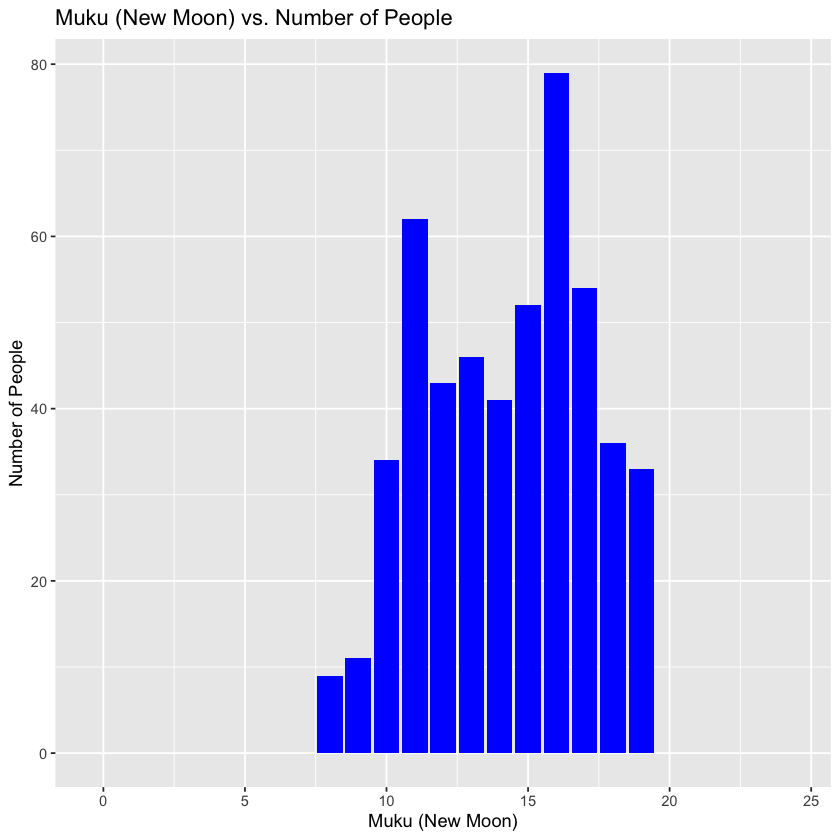

In [153]:
### Plotting Muku (New Moon) vs. Number of People
ggplot(Muku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "blue")+
    labs(title = "Muku (New Moon) vs. Number of People", 
         x ="Muku (New Moon)", y = "Number of People")

In [154]:
### Making 'Olekukolu (Half Moon) phase dataframe
Olekukolu <-DiamondBeach_data[31:60,] 

In [155]:
### Making 'Olekukolu (Half Moon) and Number of People dataframe
Olekukolu_people<-Olekukolu[, c("Time","People_total")]

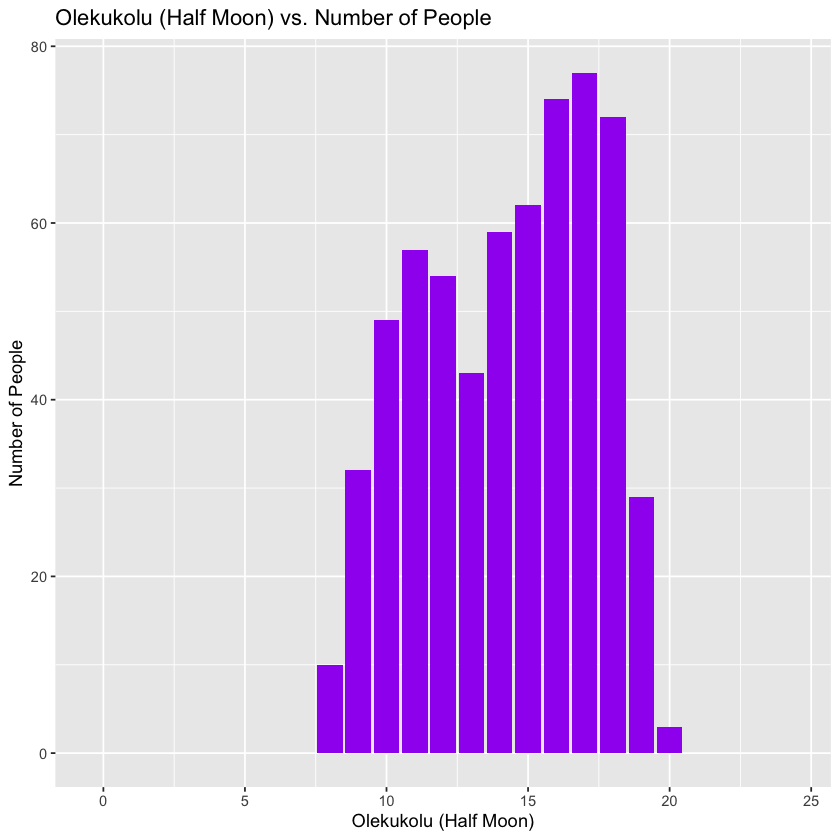

In [156]:
### Plotting Olekukolu (Half Moon) vs. Number of People
ggplot(Olekukolu_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "purple") +
    labs(title = "Olekukolu (Half Moon) vs. Number of People", 
         x ="Olekukolu (Half Moon)", y = "Number of People")

In [157]:
### Making Hoku (Full Moon) phase dataframe
Hoku <-DiamondBeach_data[61:90,] 

In [158]:
### Making Hoku (Full Moon) and Number of People dataframe
Hoku_people<-Hoku[, c("Time","People_total")]

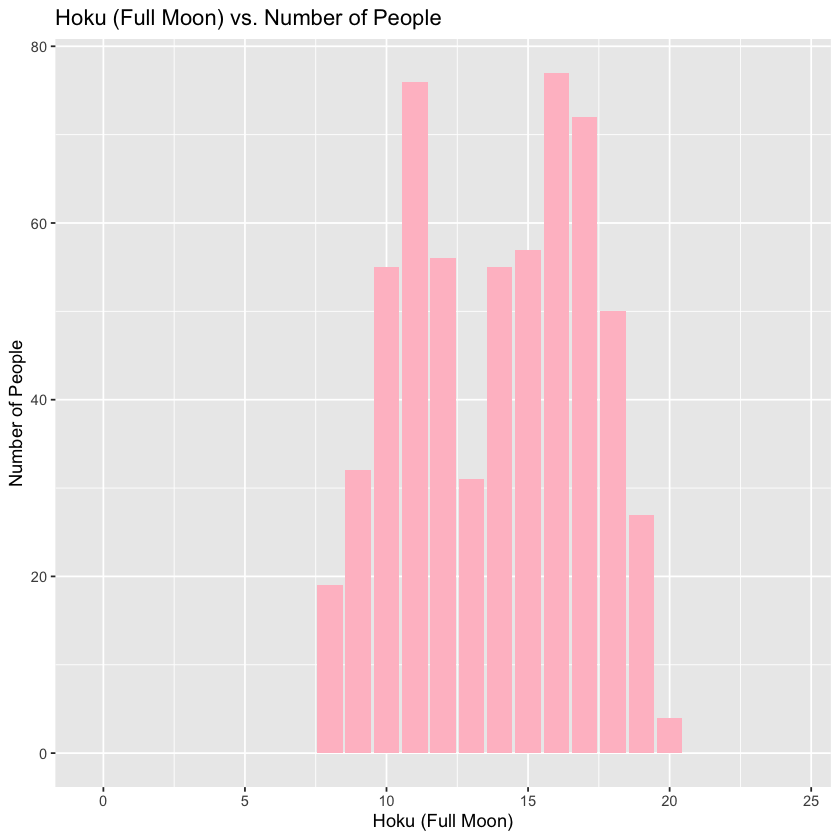

In [159]:
### Plotting Hoku (Full Moon) vs. Number of People
ggplot(Hoku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "pink") +
    labs(title = "Hoku (Full Moon) vs. Number of People", 
         x ="Hoku (Full Moon)", y = "Number of People")     

In [160]:
### Making Muku (New Moon) and Tide Height (m) dataframe
Muku_tide<-Muku[, c("Time","Tide")]

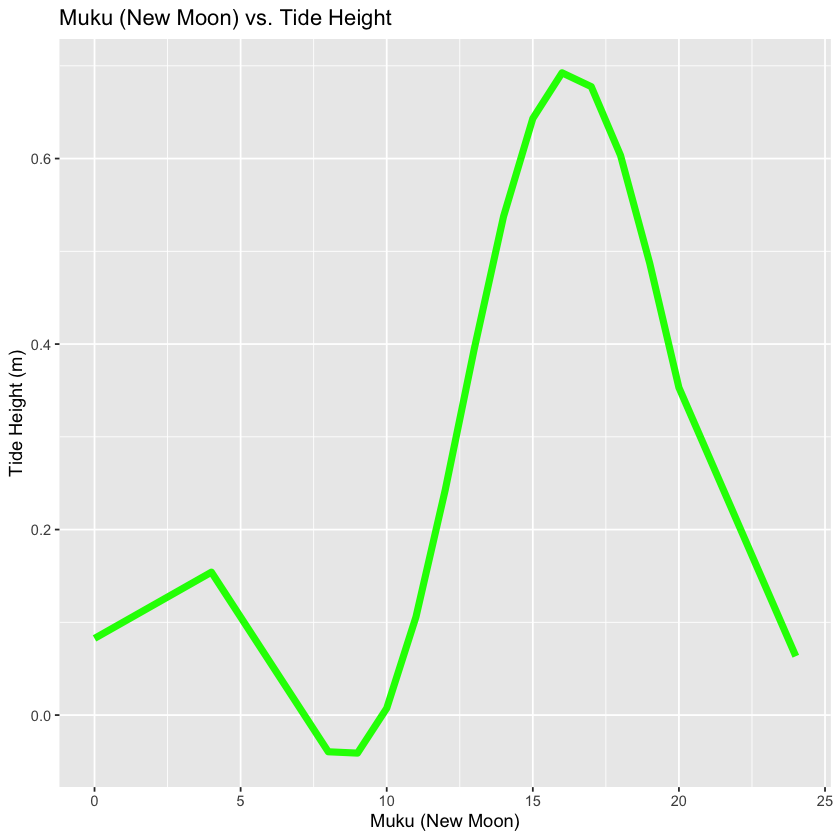

In [161]:
### Plotting Muku (New Moon) vs. Tide Height (m)
ggplot(data = Muku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "green", size = 2)+
    labs(title = "Muku (New Moon) vs. Tide Height", 
         x ="Muku (New Moon)", y = "Tide Height (m)") 

In [162]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_tide<-Olekukolu[, c("Time","Tide")]

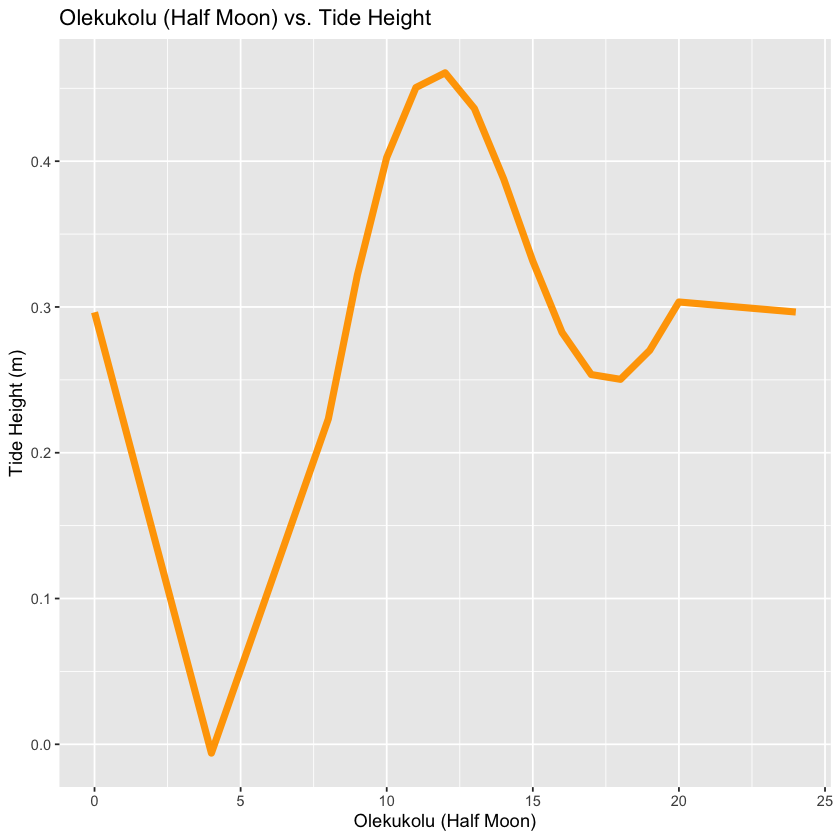

In [163]:
### Plotting 'Olekukolu (Half Moon) vs. Tide Height (m)
ggplot(data = Olekukolu_tide) +
    geom_line(aes(x = Time, y = Tide),color = "orange", size = 2)+
    labs(title = "Olekukolu (Half Moon) vs. Tide Height", 
         x ="Olekukolu (Half Moon)", y = "Tide Height (m)") 

In [164]:
### Making Hoku (Full Moon) and Tide Height (m) dataframe
Hoku_tide<-Hoku[, c("Time","Tide")]

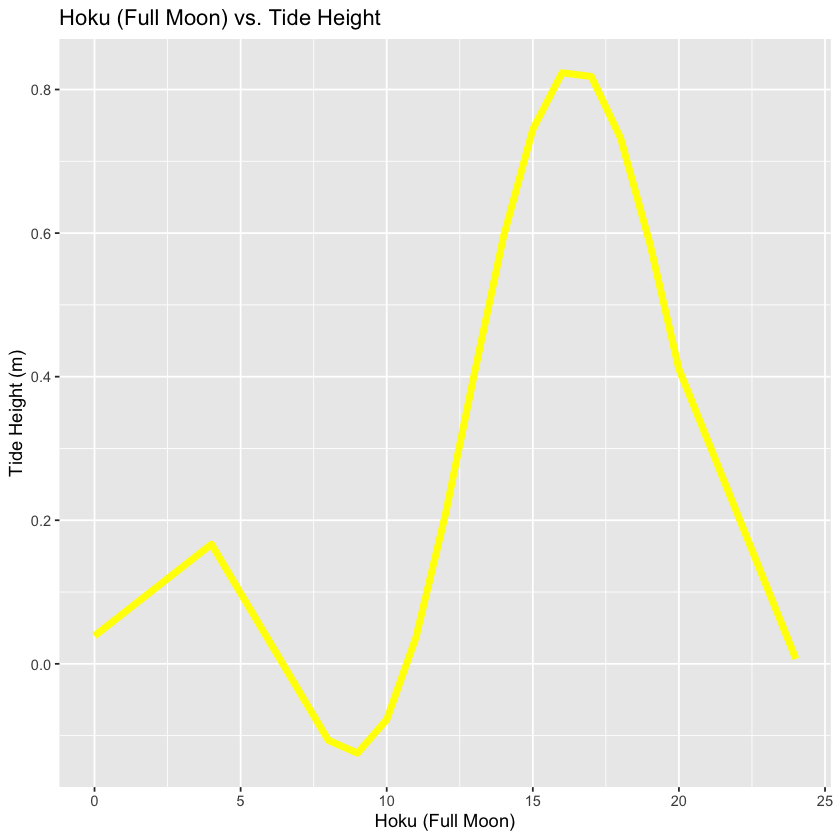

In [165]:
### Plotting Hoku (Full Moon) vs. Tide Height (m)
ggplot(data = Hoku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "yellow", size = 2)+
    labs(title = "Hoku (Full Moon) vs. Tide Height", 
         x ="Hoku (Full Moon)", y = "Tide Height (m)") 

In [166]:
### Making Muku (New Moon) and BP3 dataframe
Muku_BP3<-Muku[, c("Time","BP3")]
Muku_BP3<-na.omit(Muku_BP3)

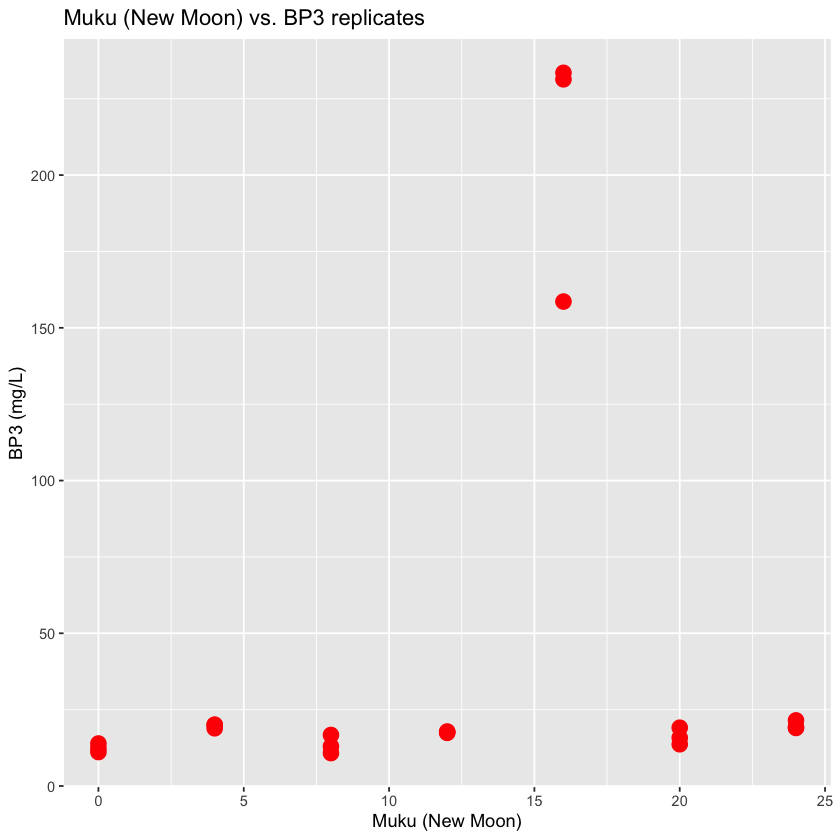

In [167]:
### Plotting Muku (New Moon) vs. BP3 replicates (mg/L)
Muku.vs.BP3.replicates <- ggplot(data = Muku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "red", size = 4)+
    labs(title = "Muku (New Moon) vs. BP3 replicates", 
         x ="Muku (New Moon)", y = "BP3 (mg/L)") 
Muku.vs.BP3.replicates

In [168]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_BP3<-Olekukolu[, c("Time","BP3")]
Olekukolu_BP3<-na.omit(Olekukolu_BP3)

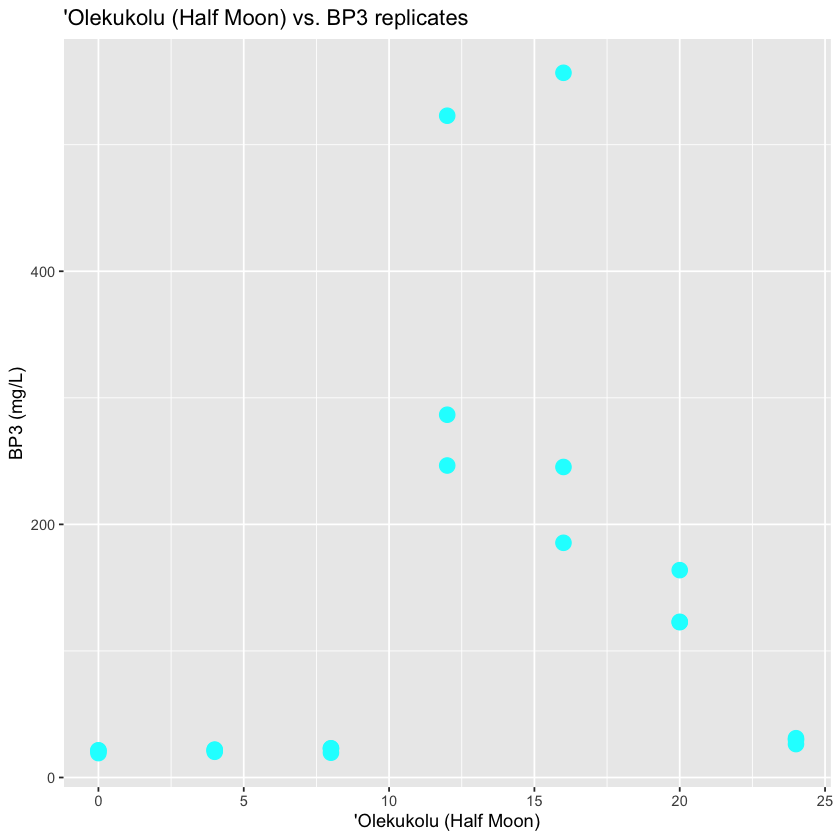

In [169]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 replicates (mg/L)
Olekukolu.vs.BP3.replicates <- ggplot(data = Olekukolu_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "cyan", size = 4)+
    labs(title = "'Olekukolu (Half Moon) vs. BP3 replicates", 
         x ="'Olekukolu (Half Moon)", y = "BP3 (mg/L)") 
Olekukolu.vs.BP3.replicates

In [170]:
### Making Hoku (Full Moon) and BP3 dataframe
Hoku_BP3<-Hoku[, c("Time","BP3")]
Hoku_BP3<-na.omit(Hoku_BP3)

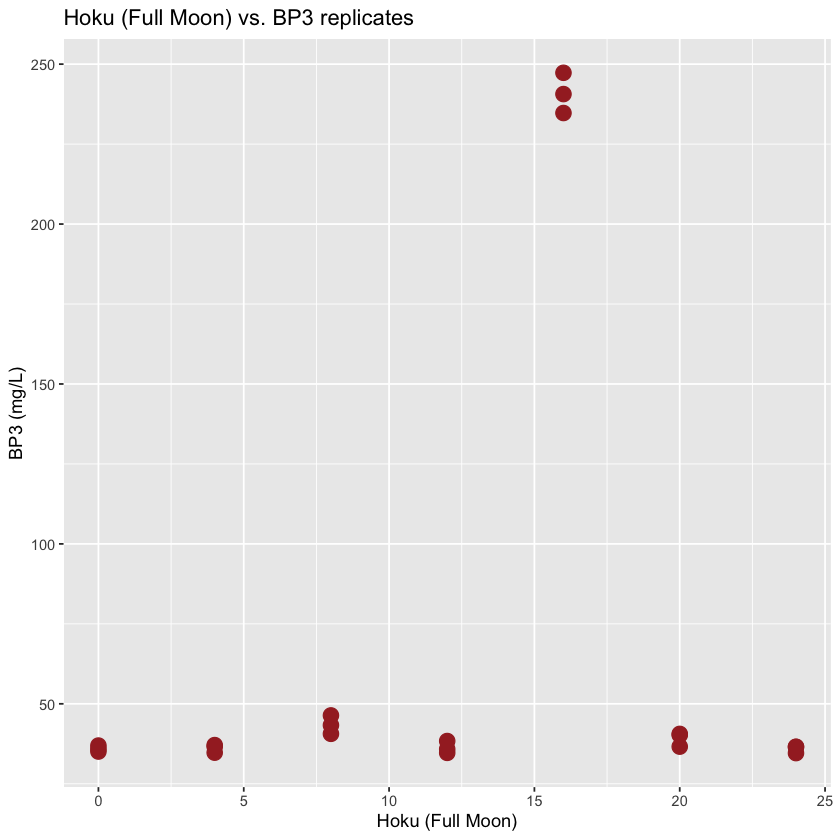

In [171]:
### Plotting Hoku (Full Moon) vs. BP3 replicates (mg/L)
Hoku.vs.BP3.replicates <- ggplot(data = Hoku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "brown", size = 4)+
    labs(title = "Hoku (Full Moon) vs. BP3 replicates", 
         x ="Hoku (Full Moon)", y = "BP3 (mg/L)") 
Hoku.vs.BP3.replicates


In [172]:
### Making Muku (New Moon) and OC dataframe
Muku_OC<-Muku[, c("Time","OC")]
Muku_OC<-na.omit(Muku_OC)

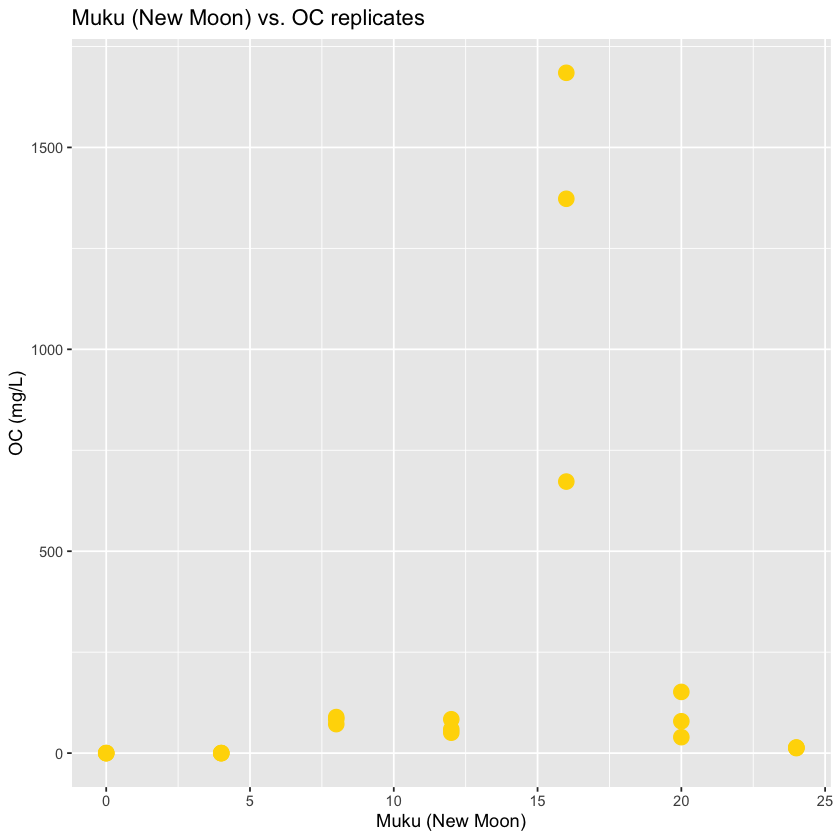

In [173]:
### Plotting Muku (New Moon) vs. OC replicates (mg/L)
Muku.vs.OC.replicates <- ggplot(data = Muku_OC) +
    geom_point(aes(x = Time, y = OC),color = "gold", size = 4)+
    labs(title = "Muku (New Moon) vs. OC replicates", 
         x ="Muku (New Moon)", y = "OC (mg/L)") 
Muku.vs.OC.replicates

In [174]:
### Making 'Olekukolu (Half Moon) and OC dataframe
Olekukolu_OC<-Muku[, c("Time","OC")]
Olekukolu_OC<-na.omit(Olekukolu_OC)

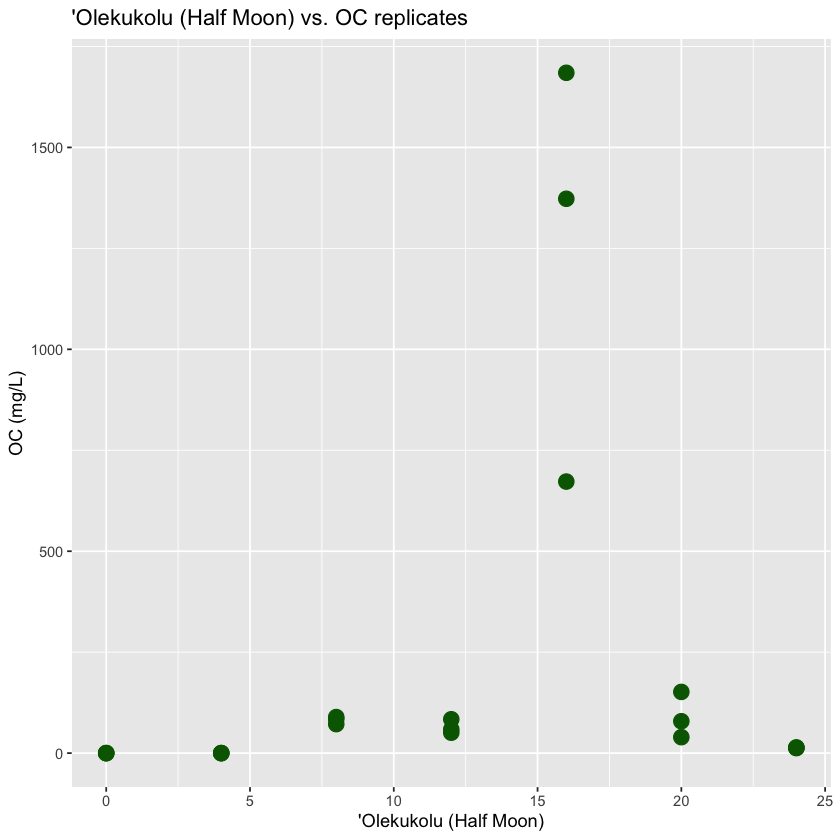

In [175]:
### Plotting 'Olekukolu (Half Moon) vs. OC replicates (mg/L)
Olekukolu.vs.OC.replicates <- ggplot(data = Olekukolu_OC) +
    geom_point(aes(x = Time, y = OC),color = "dark green", size = 4)+
    labs(title = "'Olekukolu (Half Moon) vs. OC replicates", 
         x ="'Olekukolu (Half Moon)", y = "OC (mg/L)") 
Olekukolu.vs.OC.replicates

In [176]:
### Making Hoku (Full Moon) and OC dataframe
Hoku_OC<-Hoku[, c("Time","OC")]
Hoku_OC<-na.omit(Hoku_OC)

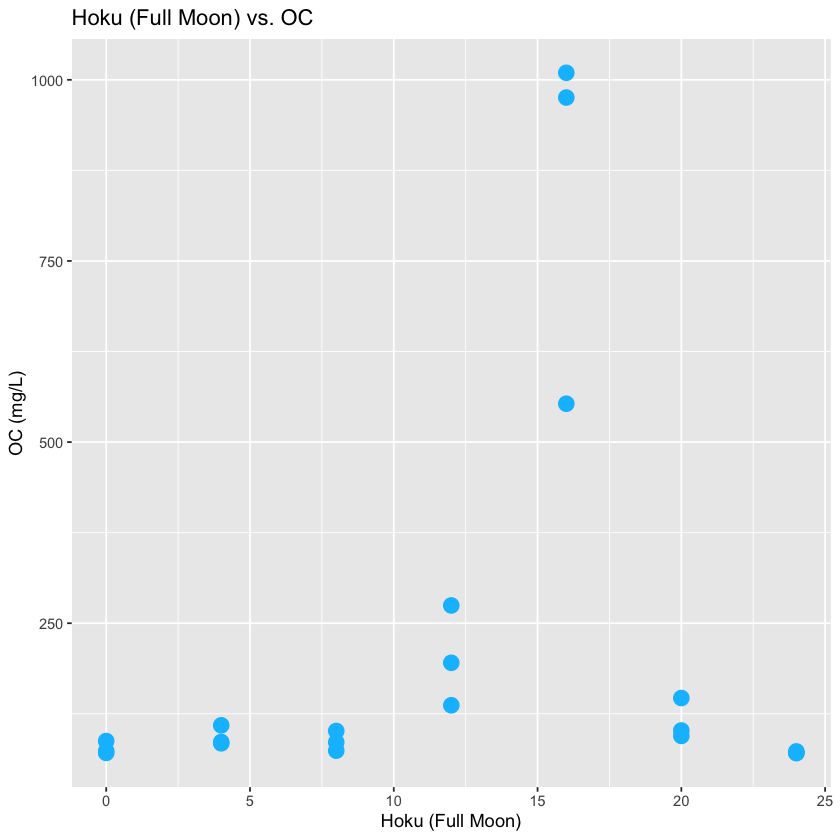

In [177]:
### Plotting Hoku (Full Moon) vs. OC replicates (mg/L)
Hoku.vs.OC.replicates <- ggplot(data = Hoku_OC) +
    geom_point(aes(x = Time, y = OC),color = "deepskyblue", size = 4)+
    labs(title = "Hoku (Full Moon) vs. OC", 
         x ="Hoku (Full Moon)", y = "OC (mg/L)") 
Hoku.vs.OC.replicates

In [178]:
### Calculate the BP3 mean for Muku values
BP3_mean <- tapply(Muku_BP3$BP3,Muku_BP3$Time,mean)

In [179]:
#data.frame(BP3_mean for Muku (New Moon))
Time_data <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_data)
combined_BP3_mean <- cbind(Time,BP3_mean)
data.frame(combined_BP3_mean)

,Time,BP3_mean
,<dbl>,<dbl>
0,0,12.45942
4,4,19.66182
8,8,13.49042
12,12,17.60934
16,16,207.80959
20,20,16.18580
24,24,19.92110


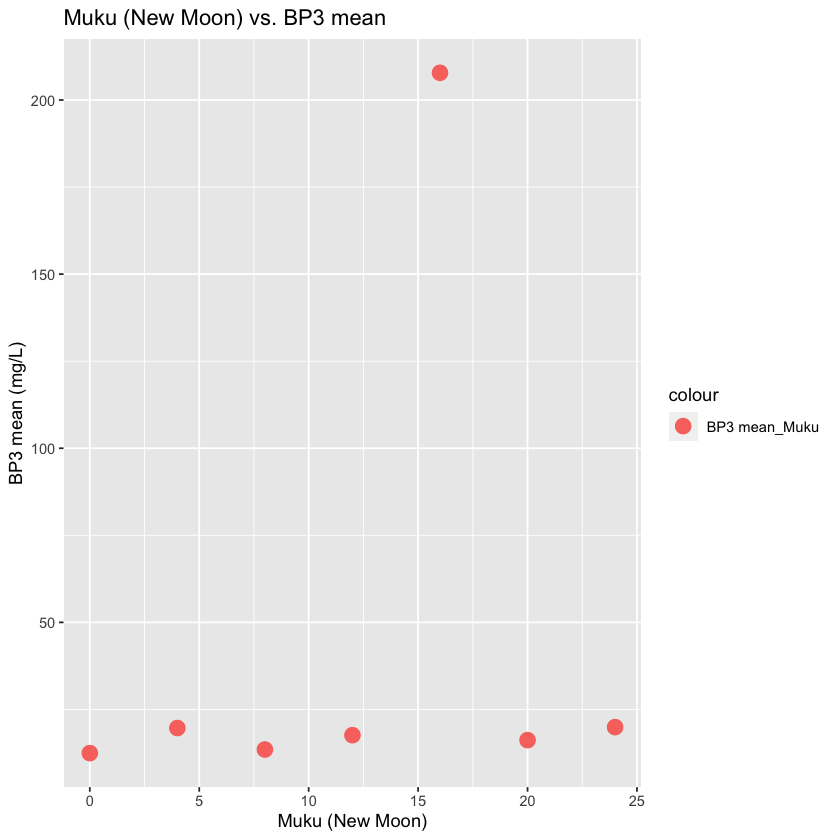

In [117]:
### Plotting Muku (New Moon) vs. BP3 mean (mg/L)
Muku.vs.BP3.mean <- qplot(Time, BP3_mean,  xlab = "Muku (New Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Muku (New Moon) vs. BP3 mean",
      size = I(4), color = "BP3 mean_Muku")
Muku.vs.BP3.mean

In [118]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
Olekukolu_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [119]:
#data.frame(BP3_mean for 'Olekukolu (Half Moon))
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Olekukolu_mean <- cbind(Time,Olekukolu_mean)
data.frame(combined_Olekukolu_mean)

,Time,Olekukolu_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121
24,24,13.23796


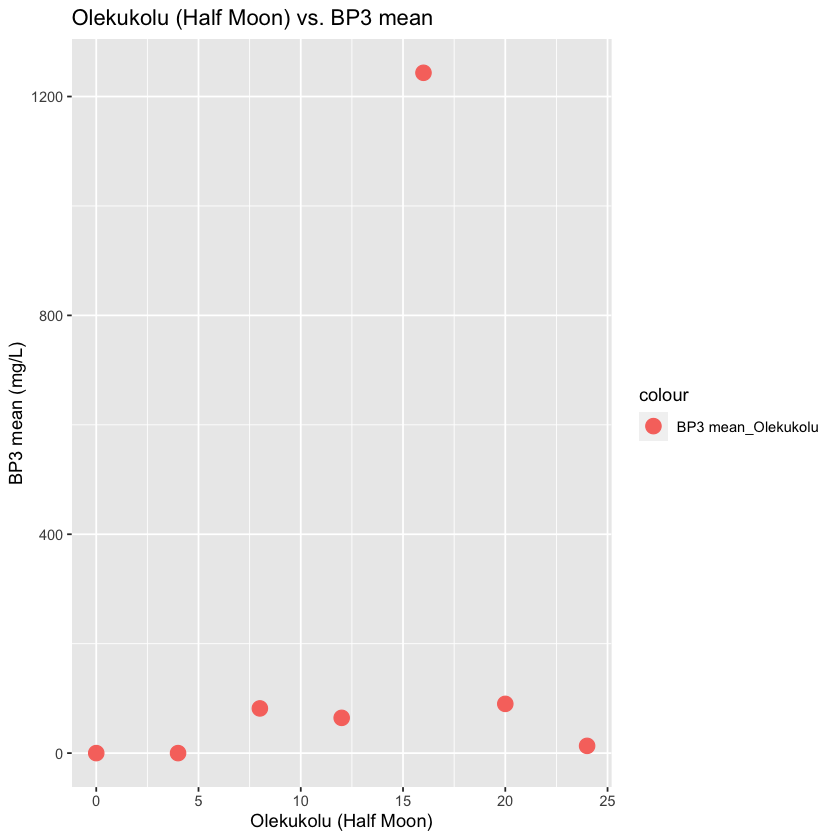

In [120]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 mean (mg/L)
Olekukolu.vs.BP3.mean <- qplot(Time, Olekukolu_mean,  xlab = "Olekukolu (Half Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Olekukolu (Half Moon) vs. BP3 mean",
      size = I(4), color = "BP3 mean_Olekukolu")
Olekukolu.vs.BP3.mean

In [121]:
### Calculate the BP3 mean for Hoku (Full Moon) values
Hoku_mean <- tapply(Hoku_BP3$BP3,Hoku_BP3$Time,mean)

In [122]:
#data.frame(BP3_mean for Hoku (Full Moon))
#(0,4,8,9,10,11,12,13,14,15,16,17,18,19,20,24)
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Hoku_mean <- cbind(Time,Hoku_mean)
data.frame(combined_Hoku_mean)

,Time,Hoku_mean
,<dbl>,<dbl>
0,0,35.97264
4,4,36.14388
8,8,43.43318
12,12,36.28882
16,16,240.88296
20,20,39.15150
24,24,35.89098


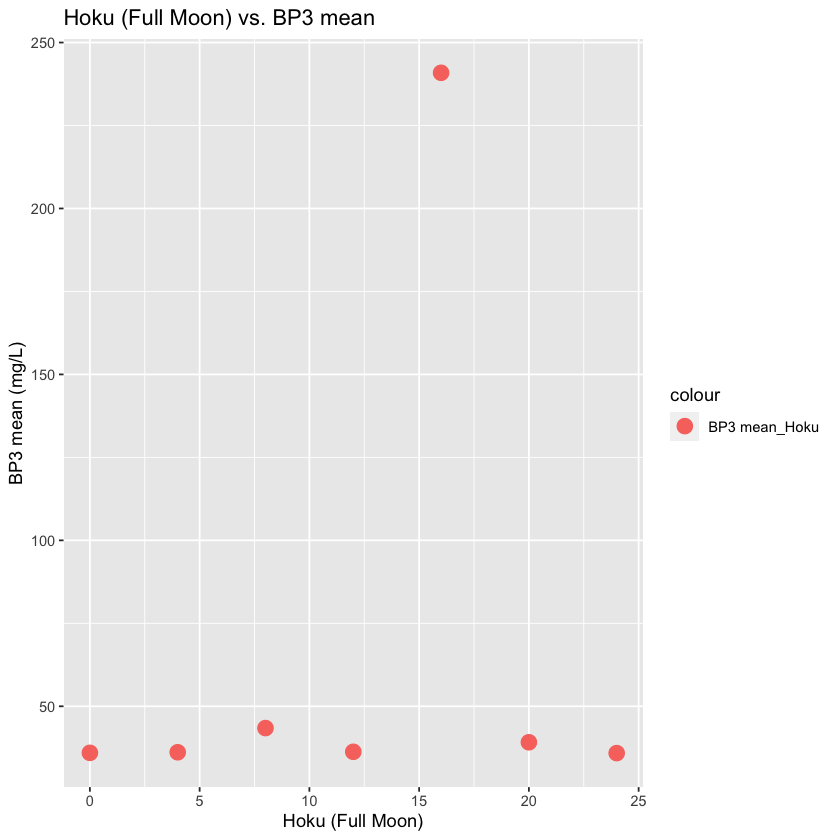

In [123]:
### Plotting Hoku (Full Moon) vs. BP3 mean (mg/L)
Hoku.vs.BP3.mean <- qplot(Time, Hoku_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Hoku (Full Moon) vs. BP3 mean",
      size = I(4), color = "BP3 mean_Hoku")
Hoku.vs.BP3.mean

In [124]:
### Calculate the OC mean for Muku (New Moon) values
OC_mean <- tapply(Muku_OC$OC,Muku_OC$Time,mean)

In [127]:
#data.frame(OC_mean) for Muku (New Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
data.frame(combined_OC_mean)

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121
24,24,13.23796


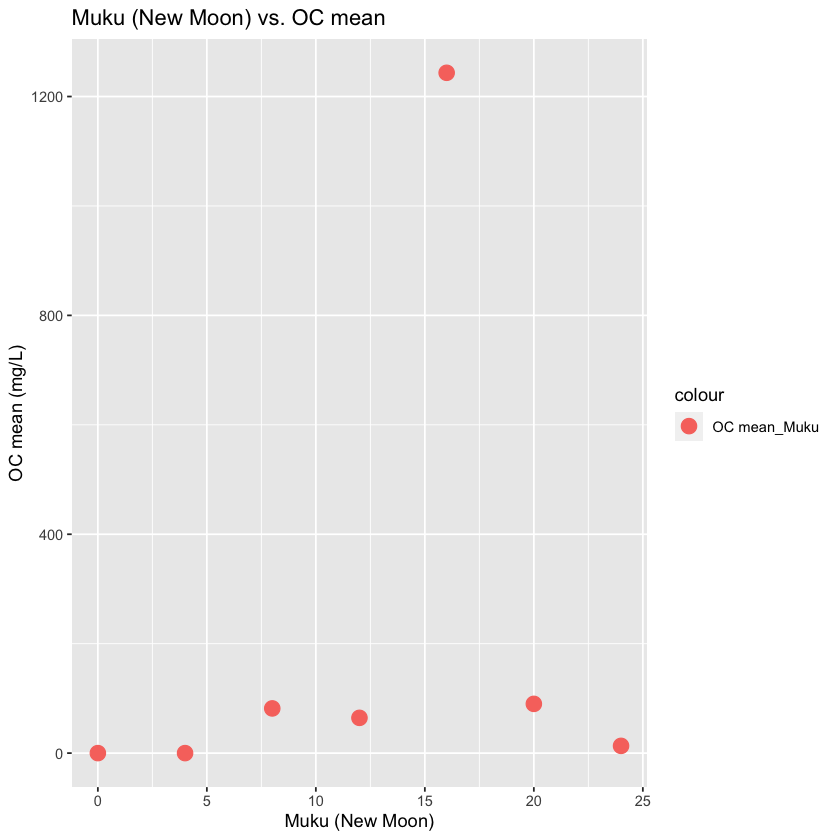

In [128]:
### Plotting Muku (New Moon) vs. OC mean (mg/L)
Muku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Muku (New Moon)",
      ylab = "OC mean (mg/L)",
      main = "Muku (New Moon) vs. OC mean",
      size = I(4), color = "OC mean_Muku")
Muku.vs.OC.mean

In [129]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
OC_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [130]:
#data.frame(OC_mean) for 'Olekukolu (Half Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
data.frame(combined_OC_mean)

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121
24,24,13.23796


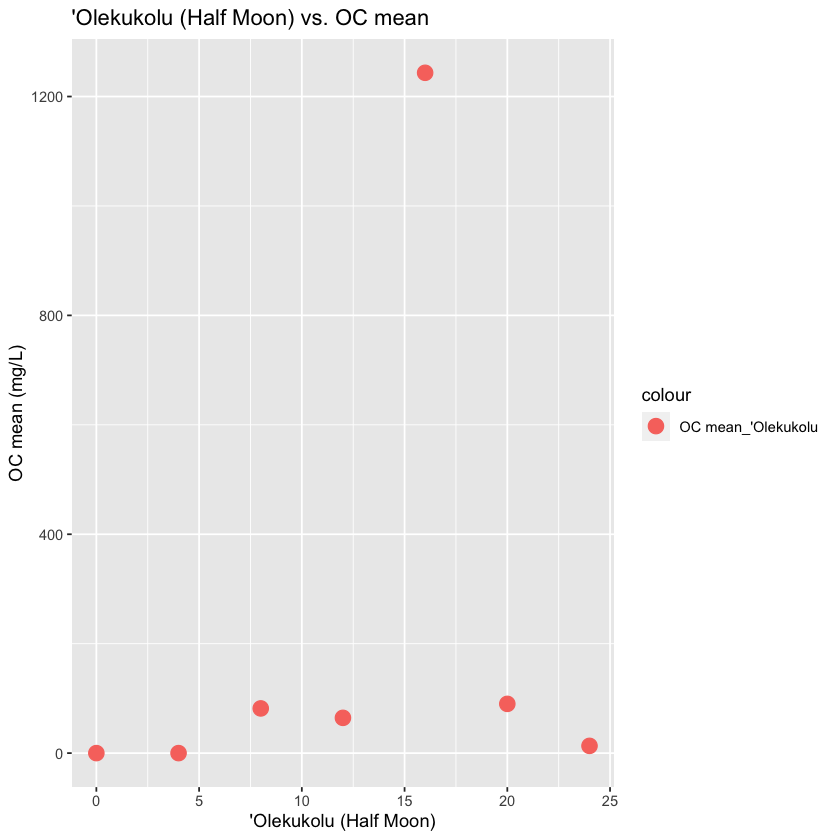

In [131]:
### Plotting 'Olekukolu (Half Moon) vs. OC mean (mg/L)
Olekukolu.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "'Olekukolu (Half Moon)",
      ylab = "OC mean (mg/L)",
      main = "'Olekukolu (Half Moon) vs. OC mean",
      size = I(4), color = "OC mean_'Olekukolu")
Olekukolu.vs.OC.mean

In [127]:
### Calculate the OC mean for Hoku (Full Moon) values
OC_mean <- tapply(Hoku_OC$OC,Hoku_OC$Time,mean)

In [132]:
#data.frame(OC_mean) for Hoku (Full Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
data.frame(combined_OC_mean)

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121
24,24,13.23796


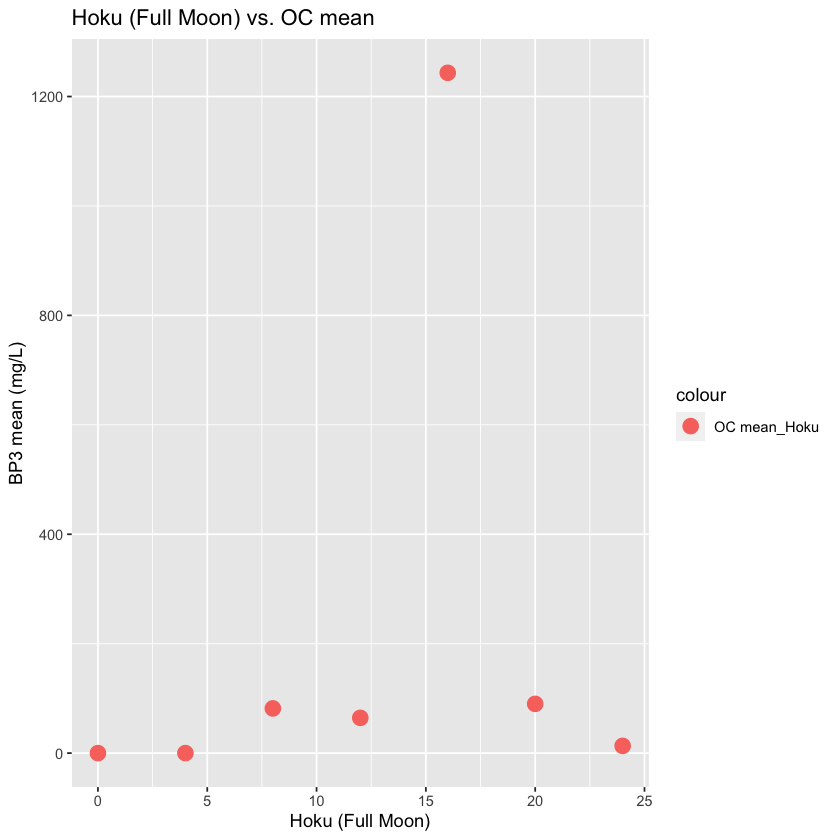

In [133]:
### Plotting Hoku (Full Moon) vs. OC mean (mg/L)
Hoku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Hoku (Full Moon) vs. OC mean",
      size = I(4), color = "OC mean_Hoku")
Hoku.vs.OC.mean

In [134]:
### Arranging all Muku (New Moon) Concentration graphs onto 1 page
grid.arrange(Muku.vs.BP3.replicates, Muku.vs.OC.replicates, Muku.vs.BP3.mean, Muku.vs.OC.mean, nrow = 4)

ERROR: Error in grid.arrange(Muku.vs.BP3.replicates, Muku.vs.OC.replicates, Muku.vs.BP3.mean, : could not find function "grid.arrange"


In [135]:
### Arranging all Olekukolu (Half Moon) Concentration graphs onto 1 page
grid.arrange(Olekukolu.vs.BP3.replicates, Olekukolu.vs.OC.replicates, Olekukolu.vs.BP3.mean, Olekukolu.vs.OC.mean,nrow = 4)

ERROR: Error in grid.arrange(Olekukolu.vs.BP3.replicates, Olekukolu.vs.OC.replicates, : could not find function "grid.arrange"


In [136]:
### Arranging all Hoku (Full Moon) Concentration graphs onto 1 page
grid.arrange(Hoku.vs.BP3.replicates, Hoku.vs.OC.replicates, Hoku.vs.BP3.mean, Hoku.vs.OC.mean, nrow = 4 )

ERROR: Error in grid.arrange(Hoku.vs.BP3.replicates, Hoku.vs.OC.replicates, Hoku.vs.BP3.mean, : could not find function "grid.arrange"


In [137]:
### Arranging all Concentration graphs onto 1 page
grid.arrange(Muku.vs.BP3.replicates, Olekukolu.vs.BP3.replicates, Hoku.vs.BP3.replicates, 
             Muku.vs.BP3.mean, Olekukolu.vs.BP3.mean, Hoku.vs.BP3.mean, 
             Muku.vs.OC.replicates, Olekukolu.vs.OC.replicates, Hoku.vs.OC.replicates, 
             Muku.vs.OC.mean, Olekukolu.vs.OC.mean, Hoku.vs.OC.mean, nrow = 4)

ERROR: Error in grid.arrange(Muku.vs.BP3.replicates, Olekukolu.vs.BP3.replicates, : could not find function "grid.arrange"


# Linear mixed model creation

This section uses the 'lme4' and 'lm' packages

In [180]:
# This is the start of mixed model creation

In [181]:
# The values need to be scaled for the appropriate model

In [182]:
Diamond_all_fin <- read.csv("DiamondBeach_all.csv")
Diamond_all_fin<-na.omit(Diamond_all_fin)

In [183]:
Diamond_all_fin$ppl_msq_s <- scale(Diamond_all_fin$ppl_msq) 

In [184]:
Diamond_all_fin$Time_s <- scale(Diamond_all_fin$Time) 

In [185]:
Diamond_all_fin$Tide_s <- scale(Diamond_all_fin$Tide) 

In [186]:
Diamond_all_fin$Time <- as.numeric(Diamond_all_fin$Time)

In [187]:
Diamond_all_fin = Diamond_all_fin %>%
mutate(Moon_s = recode(Diamond_all_fin$Moon, 
                      "Muku" = 1, 
                      "Olekukolu" = 2, 
                      "Hoku" = 3))

In [188]:
Diamond_all_fin

,X,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Tide,PreTide,PostTide,ppl_msq_s,Time_s,Tide_s,Moon_s
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
1,1,Muku,20220628,0,12.34324,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
2,2,Muku,20220628,0,13.92103,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
3,3,Muku,20220628,0,11.11400,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
4,4,Muku,20220628,4,20.03424,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
5,5,Muku,20220628,4,20.05967,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
6,6,Muku,20220628,4,18.89155,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
7,7,Muku,20220628,8,10.77351,84.056500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
8,8,Muku,20220628,8,16.71569,89.256500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
9,9,Muku,20220628,8,12.98207,71.756500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1


In [194]:
# Time of day effect on people m^2 using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_ppl_msq <- lm(ppl_msq ~ Time, data = Diamond_all_fin)
summary(T_o_D_ppl_msq)


Call:
lm(formula = ppl_msq ~ Time, data = Diamond_all_fin)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.003442 -0.002641 -0.001616  0.002806  0.006969 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 1.616e-03  8.121e-04   1.990   0.0511 .
Time        7.607e-05  5.631e-05   1.351   0.1817  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003576 on 61 degrees of freedom
Multiple R-squared:  0.02905,	Adjusted R-squared:  0.01313 
F-statistic: 1.825 on 1 and 61 DF,  p-value: 0.1817


In [190]:
# Time of day effect on tide using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_Tide <- lm(Tide ~ Time_s, data = Diamond_all_fin)
summary(T_o_D_Tide)


Call:
lm(formula = Tide ~ Time_s, data = Diamond_all_fin)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33847 -0.08713 -0.00551  0.04405  0.55094 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.23577    0.02735   8.620  3.8e-12 ***
Time_s       0.07375    0.02757   2.675  0.00958 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2171 on 61 degrees of freedom
Multiple R-squared:  0.105,	Adjusted R-squared:  0.09031 
F-statistic: 7.155 on 1 and 61 DF,  p-value: 0.009583


In [191]:
# LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.time.ppl)

ERROR: Error in lmer(BP3 ~ Time_s + ppl_msq_s + (1 | Moon_s), data = Diamond_all_fin): could not find function "lmer"


In [41]:
# LMM2
# Concentration of OC by time of day and ppl_msq
OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.time.ppl)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1343.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4928 -0.5148 -0.0310  0.2059  6.2195 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  13164   114.7   
 Residual             249641   499.6   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  238.326     84.626   1.999   2.816    0.106    
Time_s        18.656     54.145  85.026   0.345    0.731    
ppl_msq_s    235.342     54.260  85.456   4.337 3.93e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Time_s
Time_s     0.000       
ppl_msq_s  0.000 -0.208

In [42]:
# LMM3
# Concentration of BP3 off tide, time, and ppl_msq
BP3.vs.all <- lmer(BP3 ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1044.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4127 -0.6311 -0.0469  0.3015  4.5671 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  543.6   23.32   
 Residual             8744.6   93.51   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)   
(Intercept)   56.185     16.684  1.997   3.368  0.07818 . 
Tide_s        11.789     12.600 84.066   0.936  0.35211   
Time_s         2.782     10.670 84.013   0.261  0.79496   
ppl_msq_s     32.289     11.989 84.394   2.693  0.00854 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.000              
Time_s     0.000 -0.313       
ppl_msq_s  0.

In [43]:
# LMM4
# Concentration of OC off tide, time, and ppl_msq
OC.vs.all <- lmer(OC ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1332.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3713 -0.4853 -0.0012  0.2005  6.1741 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  12828   113.3   
 Residual             250965   501.0   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)  238.326     84.051   1.999   2.835   0.1052   
Tide_s        51.357     67.497  84.076   0.761   0.4489   
Time_s         5.039     57.160  84.017   0.088   0.9300   
ppl_msq_s    209.399     64.218  84.444   3.261   0.0016 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.000              
Time_s     0.000 -0.313       
ppl_msq_s

In [44]:
# LMM5
# Concentration of BP3 versus ppl_msq and tide, where interactiosn with time are considered
BP3.vs.pple.tide.inttime <- lmer(BP3 ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.pple.tide.inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ ppl_msq + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1332.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4928 -0.5148 -0.0310  0.2059  6.2195 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  13164   114.7   
 Residual             249641   499.6   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     3.824    100.423     3.940   0.038    0.971    
ppl_msq     65725.584  15153.596    85.456   4.337 3.93e-05 ***
Time_s         18.656     54.145    85.026   0.345    0.731    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) ppl_ms
ppl_msq -0.538       
Time_s   0.112 -0.208

In [45]:
# LMM6
# Concentration of OC versus ppl_msq and tide, where interactiosn with time are considered
OC.vs.pple.tide.inttime <- lmer(OC ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.pple.tide.inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ ppl_msq + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1040.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5571 -0.5514 -0.0498  0.2424  4.4539 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  551.7   23.49   
 Residual             8729.9   93.43   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    18.076     19.575     3.698   0.923 0.411992    
ppl_msq     10681.067   2834.192    85.408   3.769 0.000301 ***
Time_s          5.907     10.125    85.021   0.583 0.561152    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) ppl_ms
ppl_msq -0.517       
Time_s   0.107 -0.208

In [ ]:
# LMM7
# Effect of tide, pretide and posttide (w/ time of day interaction) [BP3].
BP3_tide_pre_post_inttime <- lmer(BP3 ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post_inttime)

In [ ]:
# LMM8
# Effect of tide, pretide and posttide (w/ time of day interaction) [OC].
OC_tide_pre_post_inttime <- lmer(OC ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post_inttime)

In [46]:
# LMM9
# Effect of pretide and posttide (w/ time of day interaction) on [BP3].
BP3_pre_post <- lmer(BP3 ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1019.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4601 -0.4767 -0.0961  0.1820  4.7531 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  911.6   30.19   
 Residual             8932.9   94.51   
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)        2.260     31.363   8.866   0.072  0.94415   
PreTide           63.924     64.251  73.659   0.995  0.32304   
Time_s           -26.071     23.882  80.184  -1.092  0.27825   
PostTide         103.004     46.509  82.652   2.215  0.02953 * 
PreTide:Time_s    29.832     69.845  66.292   0.427  0.67068   
Time_s:PostTide  224.697     78.328  83.186   2.869  0.00522 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.0

In [47]:
# LMM10
# Effect of pretide and posttide (w/ time of day interaction) on [OC].
OC_pre_post <- lmer(OC ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 1307.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9841 -0.5275 -0.1547  0.1701  6.1008 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)   9237    96.11  
 Residual             280987   530.08  
Number of obs: 90, groups:  Moon_s, 3

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)  
(Intercept)      -114.74     155.67   15.22  -0.737   0.4723  
PreTide           648.21     347.80   46.09   1.864   0.0687 .
Time_s            -48.51     130.65   63.08  -0.371   0.7116  
PostTide          669.66     260.22   83.04   2.573   0.0118 *
PreTide:Time_s   -142.69     374.42   33.79  -0.381   0.7055  
Time_s:PostTide   746.07     431.88   75.62   1.727   0.0882 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

In [ ]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post)

In [ ]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post)

In [ ]:
# LMM13
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_all <- lmer(BP3 ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_all)

In [ ]:
# LMM14
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_all <- lmer(OC ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_all)

# Visualization

This code is based on https://lmudge13.github.io/sample_code/mixed_effects.html.
The packages used include cowplot, sjPlot, sjmisc, effect and sjstats.

In [66]:
# Loading packages used here

In [67]:
my_packages_2 <- c("cowplot", "sjPlot", "sjmisc", "effect", "sjstats")

In [68]:
lapply(my_packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [ ]:
# Viz of LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)

In [ ]:
sjPlot::tab_model(BP3.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Oxybenzone Concentrations")

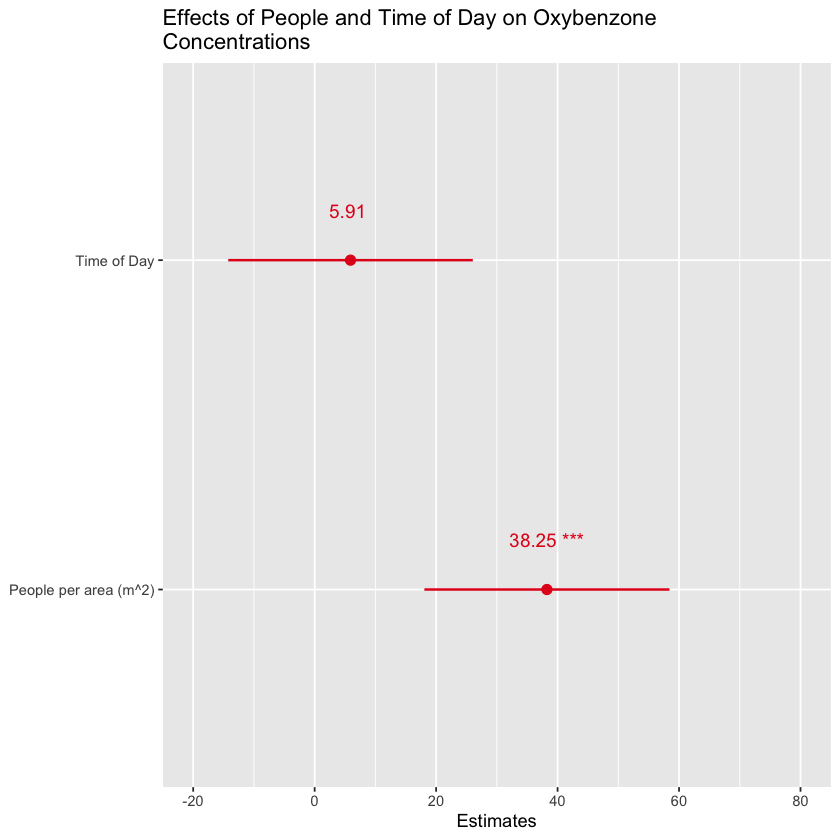

In [71]:
sjPlot::plot_model(BP3.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Oxybenzone Concentrations")

In [ ]:
BP3effects_ppl <- effects::effect(term= "ppl_msq_s", mod= BP3.vs.time.ppl)
#summary(BP3effects_ppl)

In [ ]:
BP3_ppl <- as.data.frame(BP3effects_ppl)

In [ ]:
BP3ppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Oxybenzone Concentrations")

BP3ppl_plot

In [ ]:
# LMM2
# Concentration of OC by time of day and ppl_msq
OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.time.ppl)

In [ ]:
sjPlot::tab_model(OC.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Octocrylene Concentrations")

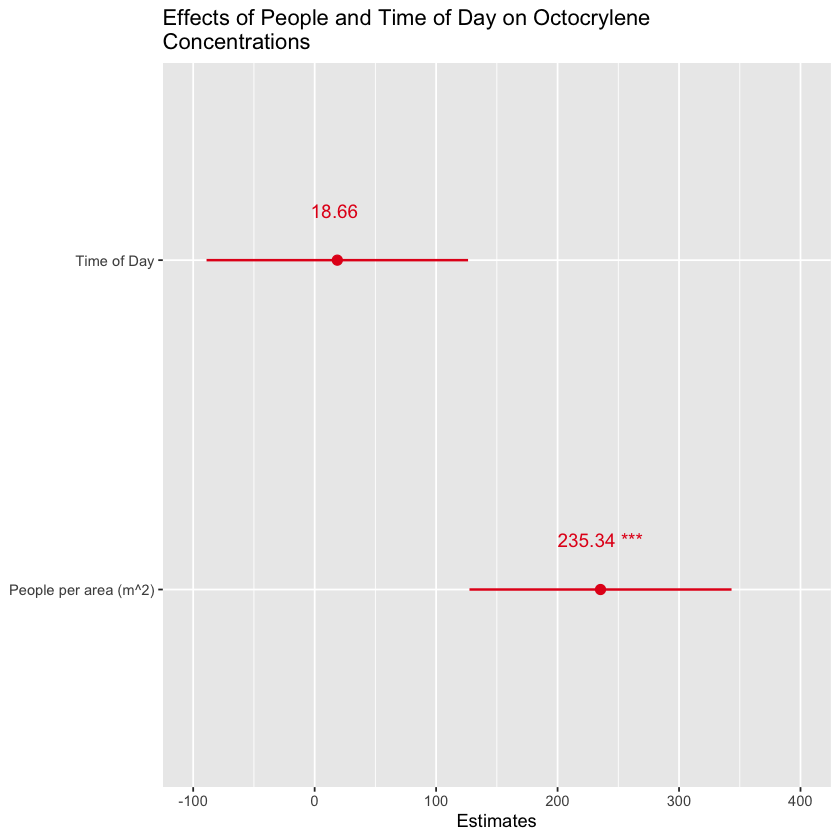

In [74]:
sjPlot::plot_model(OC.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of Day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Octocrylene Concentrations")

In [ ]:
OCeffects_ppl <- effects::effect(term= "ppl_msq_s", mod= OC.vs.time.ppl)
#summary(BP3effects_ppl)

In [ ]:
OC_ppl <- as.data.frame(OCeffects_ppl)

In [ ]:
OCppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(ppl_msq_s, OC)) + 
  #3
  geom_point(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Octocrylene Concentrations")

OCppl_plot

In [ ]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded. 
BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post)

In [ ]:
sjPlot::tab_model(BP3_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")

In [ ]:
sjPlot::plot_model(BP3_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")
```

In [ ]:
BP3effects_tide <- effects::effect(term= "Tide", mod= BP3_tide_pre_post)
#summary(BP3effects_tide)

In [ ]:
BP3_tide <- as.data.frame(BP3effects_tide)

In [ ]:
BP3tide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, BP3)) + 
  #3
  geom_point(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of Tide on Oxybenzone Concentrations")

BP3tide_plot

In [ ]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded. 
OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post)

In [ ]:
sjPlot::tab_model(OC_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

In [ ]:
sjPlot::plot_model(OC_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

In [ ]:
OCeffects_tide <- effects::effect(term= "Tide", mod= OC_tide_pre_post)
#summary(OCeffects_tide)

In [ ]:
OC_tide <- as.data.frame(OCeffects_tide)

In [ ]:
OCtide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of Tide on Octocrylene Concentrations")

OCtide_plot